In [2]:
pip install xgboost


     --------------------------------------- 70.9/70.9 MB 16.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
data=pd.read_csv('BTC-USD.csv')
data = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [5]:
data.head()

,date,open,high,low,close,adj_close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
data.tail()

,date,open,high,low,close,adj_close,volume
2708,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,22721659051
2709,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,19792547657
2710,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
2711,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563,40030.976563,23310007704
2712,2022-02-19,40022.132813,40246.027344,40010.867188,40126.429688,40126.429688,22263900160


In [8]:
data.shape

(2713, 7)

In [9]:

data.describe()

,open,high,low,close,adj_close,volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [10]:
data.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

In [11]:
data['date'] = pd.to_datetime(data.date)
data.head()

,date,open,high,low,close,adj_close,volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [12]:
print("Starting date: ",data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

Starting date:  2014-09-17 00:00:00
Ending date:  2022-02-19 00:00:00
Duration:  2712 days 00:00:00


In [13]:
y_2014 = data.loc[(data['date'] >= '2014-01-01')
                     & (data['date'] < '2015-01-01')]

y_2014.drop(y_2014[['adj_close','volume']],axis=1)

,date,open,high,low,close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
101,2014-12-27,327.583008,328.911011,312.630005,315.863007
102,2014-12-28,316.160004,320.028015,311.078003,317.239014
103,2014-12-29,317.700989,320.266998,312.307007,312.670013
104,2014-12-30,312.718994,314.808990,309.372986,310.737000


In [14]:
monthvise= y_2014.groupby(y_2014['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,412.654003,407.182428


In [19]:
closedf = data[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2713, 2)


In [20]:
closedf = closedf[closedf['date'] > '2020-09-13']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  524


In [21]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(524, 1)


In [22]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (366, 1)
test_data:  (158, 1)


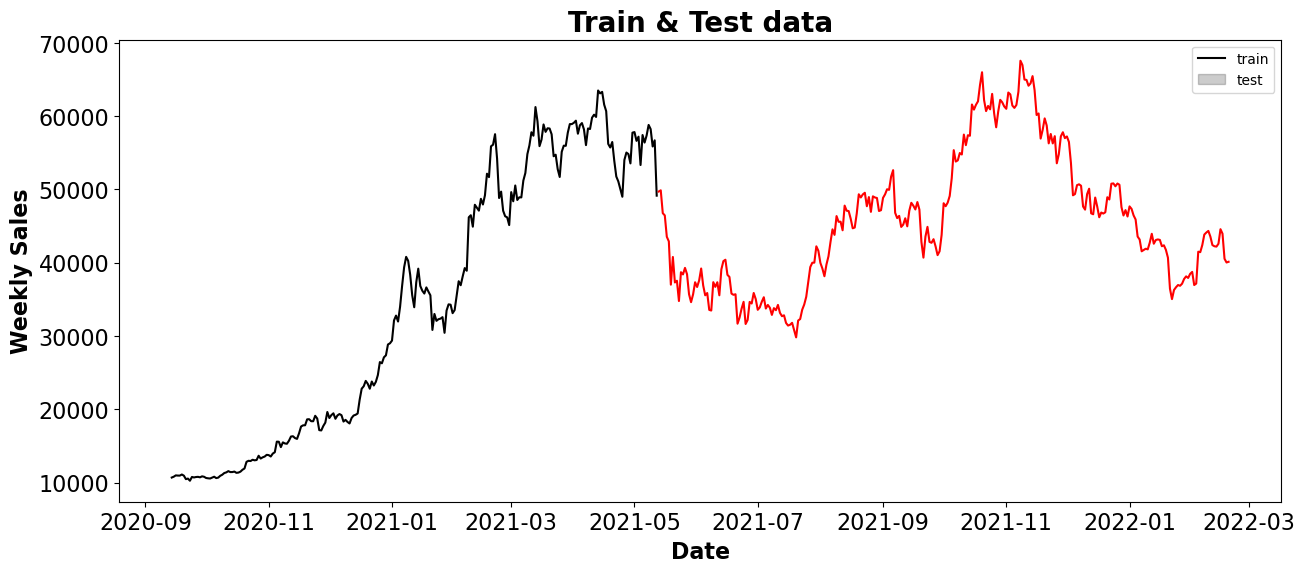

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:241], y = close_stock['close'][:241], color = 'black')
sns.lineplot(x = close_stock['date'][241:], y = close_stock['close'][241:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [24]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
time_step = 21
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (344, 21)
y_train:  (344,)
X_test:  (136, 21)
y_test (136,)


In [26]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.04643015682889229
Root Mean squared Error - RMSE : 0.06031498357634065


In [28]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (344, 1)
Test data prediction: (136, 1)


In [29]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Train predicted data:  (524, 1)
Test predicted data:  (524, 1)


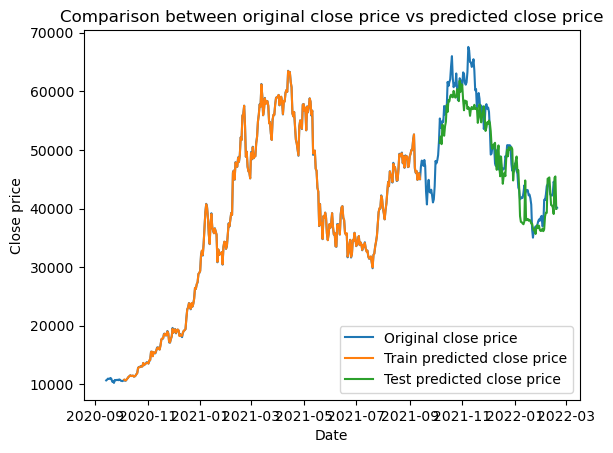

In [36]:
import matplotlib.pyplot as plt

look_back = time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# Shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

fig, ax = plt.subplots()

# Plot original close price
ax.plot(close_stock['date'], close_stock['close'], label='Original close price')

# Plot train predicted close price
train_dates = close_stock['date'].values[look_back:len(train_predict)+look_back]
train_predicted_close = trainPredictPlot[look_back:len(train_predict)+look_back].reshape(-1)
ax.plot(train_dates, train_predicted_close, label='Train predicted close price')

# Plot test predicted close price
test_dates = close_stock['date'].values[len(train_predict)+(look_back*2)+1:len(closedf)-1]
test_predicted_close = testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1].reshape(-1)
ax.plot(test_dates, test_predicted_close, label='Test predicted close price')

ax.set_xlabel('Date')
ax.set_ylabel('Close price')
ax.set_title('Comparison between original close price vs predicted close price')
ax.legend()

plt.show()
